In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter


train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

print(train_data.head())
print('===========================================================================\ntrain data set',len(train_data))
print(test_data.head())
print('===========================================================================\ntrain data set',len(test_data))

         id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1
train data set 150000
        id                                           document  label
0  6270596                                                굳 ㅋ      1
1  9274899                               GDNTOPCLASSINTHECLUB      0
2  8544678             뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아      0
3  6825595                   지루하지는 않은데 완전 막장임... 돈주고 보기에는....      0
4  6723715  3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??      0
train data set 50000


# 중복값 제거

In [2]:
# train_data 중복값확인
len(train_data)-len(train_data['document'].value_counts())

3818

In [3]:
# train_data 중복값 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

In [4]:
len(train_data)

146183

In [5]:
# test_data 중복값 확인 및 제거
len(test_data)-len(test_data['document'].value_counts())
test_data.drop_duplicates(subset=['document'], inplace=True)
len(test_data)

49158

# Null값 제거

In [6]:
# train_data set null 값 확인 및 제거
print(train_data.isnull().values.any())
train_data = train_data.dropna(how='any')
print(train_data.isnull().values.any())

True
False


In [7]:
# test_data set null 값 확인 및 제거
print(test_data.isnull().values.any())
test_data = test_data.dropna(how='any')
print(test_data.isnull().values.any())

True
False


# 토큰화 및 불용어제거

In [8]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [9]:
X_train = []
for sentence in train_data['document']:

    temp_X = tokenizer.morphs(sentence) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [10]:
X_test = []
for sentence in test_data['document']:

    temp_X = tokenizer.morphs(sentence) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [11]:
print(X_train[:3])

[['아', '더', '빙', '.', '.', '진짜', '짜증', '나', '네요', '목소리'], ['흠', '.', '..', '포스터', '보고', '초딩', '영화', '줄', '.', '...', '오버', '연기', '조차', '가볍', '지', '않', '구나'], ['너무', '재', '밓었다그래서보는것을추천한다']]


In [12]:
print(X_test[:3])

[['굳', 'ㅋ'], ['GDNTOPCLASSINTHECLUB'], ['뭐', '야', '평점', '.', '...', '나쁘', '진', '않', '지만', '10', '점', '짜리', '더더욱', '아니', '잖아']]


# word_to_index

In [13]:
words = np.concatenate(X_train).tolist()
counter = Counter(words)
counter = counter.most_common(10000-4)
vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
word_to_index = {word:index for index, word in enumerate(vocab)}

In [14]:
word_to_index['아냐']

1814

# 텍스트 스트링 -> 사전인덱스 스트링

In [15]:
def wordlist_to_indexlist(wordlist):
    return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

# train,test,split

In [16]:
X_train = list(map(wordlist_to_indexlist, X_train))
X_test = list(map(wordlist_to_indexlist, X_test))

In [17]:
y_train = np.array(list(train_data['label']))
y_test = np.array(list(test_data['label']))

In [18]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [19]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 모델 구성 데이터분석 및 가공

## 데이터셋 내 문장 길이 분포

In [20]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))
total_data_text = list(X_train) + list(X_test)

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [21]:
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

In [22]:
print('문장길이 avg : ', np.mean(num_tokens))
print('문장길이 max : ', np.max(num_tokens))
print('표준편차 : ', np.std(num_tokens))

문장길이 avg :  15.96940191154864
문장길이 max :  116
표준편차 :  12.843571191092


In [23]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_len = int(max_tokens)
print('pad_sequences maxlen : ', max_len)
print((np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  41
0.9342988343341575


# padding

In [24]:
X_train = pad_sequences(X_train, maxlen = max_len,value=word_to_index["<PAD>"],padding='pre')
X_test = pad_sequences(X_test, maxlen = max_len,value=word_to_index["<PAD>"],padding='pre')

# 모델구성

In [25]:
total_count = len(word_to_index)
print(total_count)
word_vector = 200

10000


In [26]:
# LSTM
model = keras.Sequential()
model.add(keras.layers.Embedding(10000, word_vector, input_shape=(None,)))
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               168448    
_________________________________________________________________
dense (Dense)                (None, 8)                 1032      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 2,169,489
Trainable params: 2,169,489
Non-trainable params: 0
_________________________________________________________________


# validation set

In [27]:
# train set의 20%만
X_train.shape[0]*0.2

29236.4

In [28]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1828/1828 [==============================] - 35s 18ms/step - loss: 0.4260 - acc: 0.8016 - val_loss: 0.3348 - val_acc: 0.8548

Epoch 00001: val_acc improved from -inf to 0.85477, saving model to best_model.h5
Epoch 2/15
1828/1828 [==============================] - 31s 17ms/step - loss: 0.3065 - acc: 0.8700 - val_loss: 0.3312 - val_acc: 0.8593

Epoch 00002: val_acc improved from 0.85477 to 0.85925, saving model to best_model.h5
Epoch 3/15
1828/1828 [==============================] - 31s 17ms/step - loss: 0.2773 - acc: 0.8859 - val_loss: 0.3046 - val_acc: 0.8726

Epoch 00003: val_acc improved from 0.85925 to 0.87259, saving model to best_model.h5
Epoch 4/15
1828/1828 [==============================] - 31s 17ms/step - loss: 0.2582 - acc: 0.8961 - val_loss: 0.3063 - val_acc: 0.8734

Epoch 00004: val_acc improved from 0.87259 to 0.87345, saving model to best_model.h5
Epoch 5/15
1828/1828 [==============================] - 31s 17ms/step - loss: 0.2418 - acc: 0.9027 - val_loss: 0.29

In [29]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 6s - loss: 0.3541 - acc: 0.8591
[0.3541002869606018, 0.8590638041496277]


In [30]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


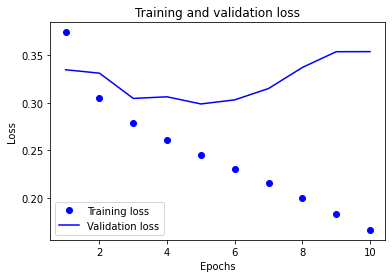

In [31]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

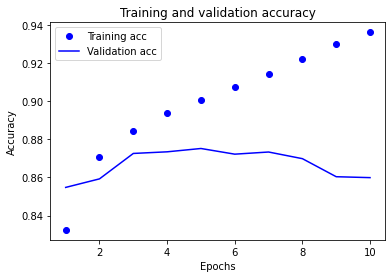

In [32]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 학습된 embedding layer 분석

In [43]:
embedding = model.layers[0]
weights = embedding.get_weights()[0]
print(weights.shape)

(10000, 200)


In [48]:
# CNN
from tensorflow.keras.initializers import Constant

# 모델 구성
model_cnn = keras.Sequential()
model_cnn.add(keras.layers.Embedding(10000, 
                                 word_vector, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=max_len, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_cnn.add(keras.layers.Conv1D(16, 5, activation='relu')) #16, 32 (추가시도)
model_cnn.add(keras.layers.MaxPooling1D(5))
model_cnn.add(keras.layers.Conv1D(16, 5, activation='relu')) #negative error가 떠서 커널 사이즈를 줄여줬다. (추가 시도)
model_cnn.add(keras.layers.GlobalMaxPooling1D())
model_cnn.add(keras.layers.Dense(16, activation='relu'))
model_cnn.add(keras.layers.Dense(1, activation='sigmoid')) 

model_cnn.summary()

NameError: name 'embedding_matrix' is not defined

FileNotFoundError: [Errno 2] No such file or directory: '/aiffel/aiffel/sentiment_classification/ko.bin'